# Data Analysis for the ADMET scores project


In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.DataStructs import BulkTanimotoSimilarity


In [90]:
df_features = pd.read_csv('../dataset/X_train_UbsWnSC.csv')

In [91]:
df_features.head()


,ID,SMILES
0,0,O=C(Nc1nncs1)c1cccnc1
1,1,COc1ccc(N2CCCN(CC3CCN(C(=O)C4CC4)CC3)CC2)cc1
2,2,Cc1[nH]nc(CCC(=O)NCCCOC2CCCC2)c1C
3,3,Cc1cc(C)n2ncc(C(=O)Nc3cccc(C(=O)O)c3)c2n1
4,4,CCn1ncnc1-c1[nH]cnc1-c1ccccc1


In [92]:
morgan_fps = []
mols = []
for smile in df_features['SMILES']:
    mol = Chem.MolFromSmiles(smile)
    fp_mor_gen = AllChem.GetMorganGenerator(radius=2)
    fp_mor = fp_mor_gen.GetFingerprint(mol)
    morgan_fps.append(fp_mor)

In [93]:
tanimoto_sims = []

for fp in morgan_fps:
    tanimoto_sims.append(BulkTanimotoSimilarity(fp, morgan_fps))

tanimoto_sims = np.array(tanimoto_sims)

/tmp/ipykernel_26873/3737500838.py:3: RuntimeWarning: divide by zero encountered in log10
  sns.heatmap(np.log10(tanimoto_sims),ax=ax, cbar_kws={'label': '$\log(tanimoto)$'})


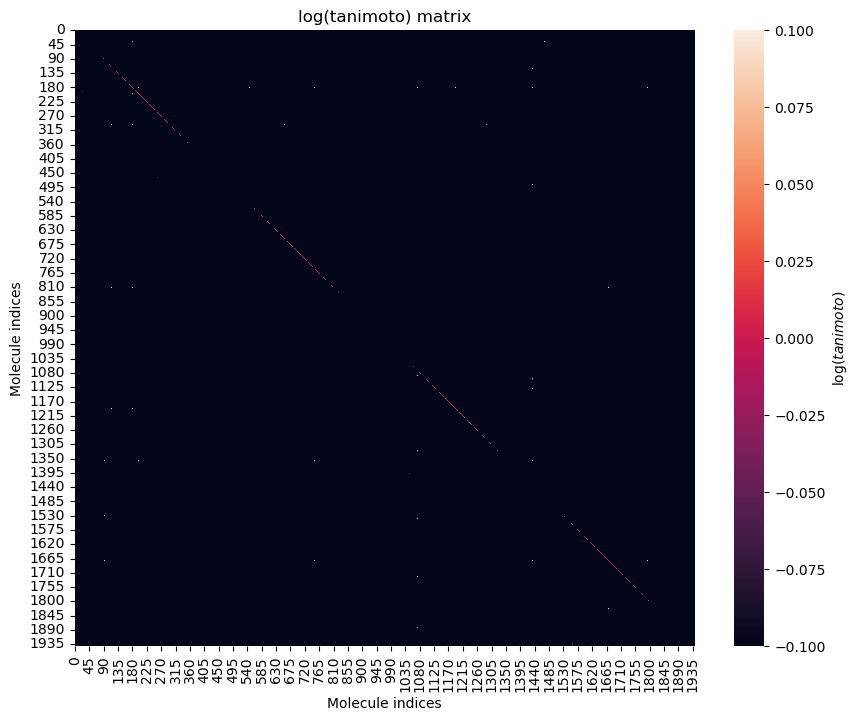

In [108]:
#sns.heatmap(np.log10(tanimoto_sims),cmap='viridis')
f,ax = plt.subplots(figsize=(10,8))
sns.heatmap(np.log10(tanimoto_sims),ax=ax, cbar_kws={'label': '$\log(tanimoto)$'})
ax.set_xlabel('Molecule indices')
ax.set_ylabel('Molecule indices')
ax.set_title('log(tanimoto) matrix')
#f.savefig('tanimoto_nocluster.png',bbox_inches='tight')

# Structural analysis of the tanimoto similarity matrix.

I'd be very helpful if we could identify clusters in the features and the labels of our data. Why?
- It is natural to think that some molecules are more similar than others chemically, and morgan fingerprints can capture this acceptably well.
- Structurally similar molecules tend to have similar chemical properties, be it equilibrium contants or ADMET scores.
- Therefore, if the Morgan fingerprints of the input can be clustered, and the labels can be clustered, we can analyze if similar molecules (as per Morgan FPs) have similar ADMET scores
- If so, wee can train a cheap classifier first, and then train a separate tree model for each category. If the classifier is good, this can help simplify our problem a lot.

In [95]:
from sklearn.cluster import AgglomerativeClustering

In [96]:
n_clusters = 200

hier_cluster_gen = AgglomerativeClustering(n_clusters, metric='precomputed', linkage='average')
dist_matrix = 1 - tanimoto_sims

cluster_identities = hier_cluster_gen.fit_predict(dist_matrix)



In [ ]:
df_clusters = pd.DataFrame({'original_index':np.arange(len(cluster_identities)), 'cluster_label':cluster_identities})
df_sorted = df_clusters.sort_values(by='cluster_label')
reordered_idxs= df_sorted['original_index'].values
reordered_tanimoto = tanimoto_sims[reordered_idxs, :] #Reorder the rows
reordered_tanimoto = reordered_tanimoto[:, reordered_idxs]

/tmp/ipykernel_26873/1563083463.py:2: RuntimeWarning: divide by zero encountered in log10
  sns.heatmap(np.log10(reordered_tanimoto), cbar_kws={'label': 'Similitud Tanimoto'})


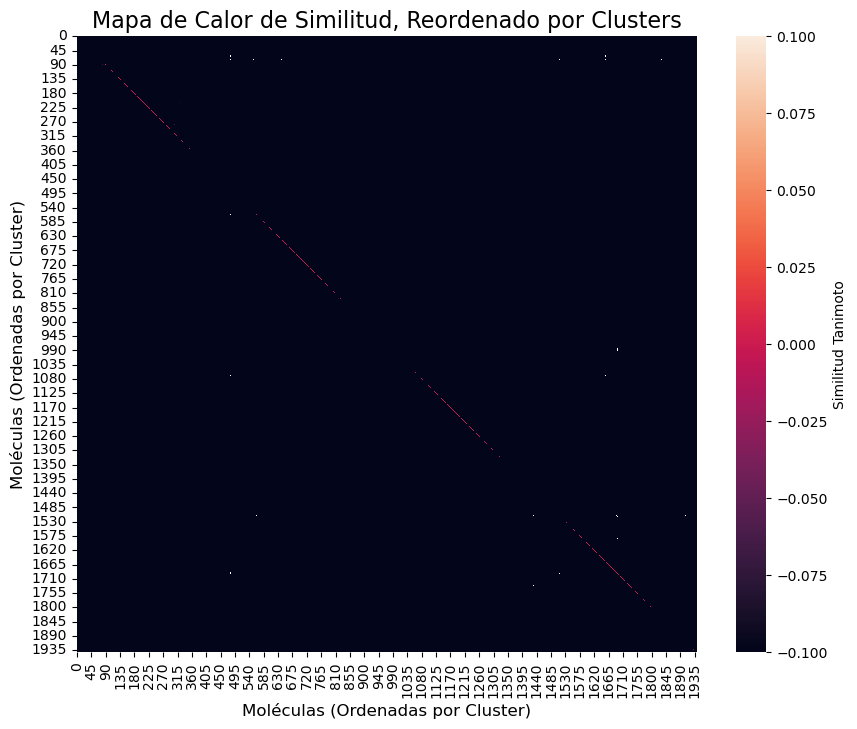

In [109]:
plt.figure(figsize=(10, 8))
sns.heatmap(np.log10(reordered_tanimoto), cbar_kws={'label': 'Similitud Tanimoto'})
plt.title('Mapa de Calor de Similitud, Reordenado por Clusters', fontsize=16)
plt.xlabel('Moléculas (Ordenadas por Cluster)', fontsize=12)
plt.ylabel('Moléculas (Ordenadas por Cluster)', fontsize=12)
plt.show()


In [112]:
# We use the silhouette method to look the optimum number of clusters in our molecule dataset. 
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import squareform #A condensed, machine-efficient square matrix to profit from symmetry.

efficient_distance = squareform(dist_matrix)
clustering_tree = linkage(efficient_distance, metric='average') #Again, a faster way to compute the whole tree.
k_range = range(2, 21)
silhouette_scores = []
for k in k_range:
    cluster_labels = fcluster(clustering_tree, k, criterion='maxclust')
    score = silhouette_score(dist_matrix, cluster_labels, metric='precomputed')
    silhouette_scores.append(score)





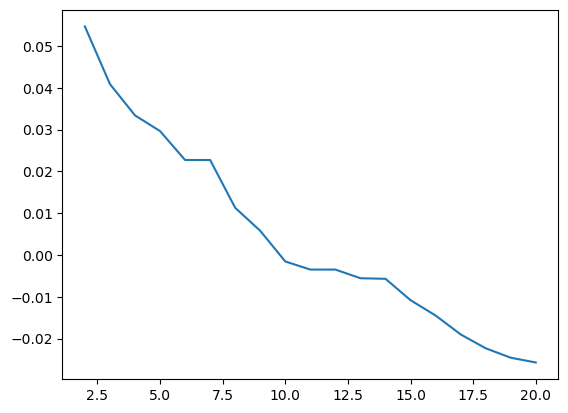

In [114]:
plt.plot(k_range,silhouette_scores)

range(2, 21)